## Gradient penalty WGAN

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
from tqdm import tqdm, tqdm_notebook
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as utils_data
import torch.nn.functional as F
import os

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(16345);

Wasserstein GAN: arXiv:1701.07875 <br>
WGAN gradient penalty: arXiv:1704.00028

In [9]:
# layer in the discriminator and generator are concatenation of linear + LRelu

class LReluLayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(LReluLayer, self).__init__()
        
        self.n_in = n_in
        self.n_out = n_out
        
        self.lin = nn.Linear(self.n_in, self.n_out)
        
    def forward(self, x):
        x = F.leaky_relu(self.lin(x))

        return x

In [153]:
# n_hidd is a vector of length (num_layers + 1). 
# The first entry is the number of noise variables
# last entry is the dimension of the sample in the dataset
# the other entries are the number of hidden nodes in the linear layers

class Generator(nn.Module):
    def __init__(self, n_hidd):
        super(Generator, self).__init__()

        self.n_hidd = n_hidd
        self.generator = nn.ModuleList()
        for i in range(len(self.n_hidd) - 1):
            self.generator  += [LReluLayer(self.n_hidd[i], self.n_hidd[i + 1])]
        self.generator  += [nn.Linear(self.n_hidd[-1], 2)]
                    
    def forward(self, x):
        for layer in self.generator:
            x = layer(x)
        return x

In [17]:
# the last layer of the discriminator has a single neuron as output
# remember the discriminator IS NOT A CLASSIFIER!

class Discriminator(nn.Module):
    def __init__(self, n_hidd):
        super(Discriminator, self).__init__()

        self.n_hidd = n_hidd
        self.discriminator = nn.ModuleList()
        for i in range(len(self.n_hidd) - 1):
            self.discriminator  += [LReluLayer(self.n_hidd[i], self.n_hidd[i + 1])]
        self.discriminator  += [nn.Linear(self.n_hidd[-1], 1)]
                    
    def forward(self, x):
        for layer in self.discriminator:
            x = layer(x)
        return x

In [194]:
BATCH_SIZE = 256
ITERS = 10000
CRITIC_ITERS = 5

In [195]:
def gradient_penalty(disc, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1, device=device, requires_grad=True)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    disc_interpolates = disc(interpolates)
    gradients = torch.autograd.grad(outputs=disc_interpolates, 
                              inputs=interpolates, 
                              grad_outputs=torch.ones(disc_interpolates.size()),
                              create_graph=True, retain_graph=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

def disc_loss(disc, real_data, fake_data, gp_lambda=10):
    return((disc(fake_data) - disc(real_data)).mean() + gp_lambda * gradient_penalty(disc, real_data, fake_data))

def gen_loss(disc, fake_data):
    return -disc(fake_data).mean()

In [196]:
# test with the 8 gauss toy model
def dataset_gen(label_dset):
    if label_dset == '8gauss':
        scale = 2.
        centers = [
            (1, 0),
            (-1, 0),
            (0, 1),
            (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        centers = [(scale * x, scale * y) for x, y in centers]
        while True:
            dataset = torch.randn(BATCH_SIZE, 2) * .02
            for i in range(BATCH_SIZE):
                center = random.choice(centers)
                dataset[i][0] += center[0]
                dataset[i][1] += center[1]
            dataset /= 1.414  # stdev
            yield dataset
        

In [197]:
dset = dataset_gen('8gauss')

netD = Discriminator([2, 512, 512, 512])
netG = Generator([2, 512, 512, 512])

optimizerD = torch.optim.Adam(netD.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizerG = torch.optim.Adam(netG.parameters(), lr=1e-4, betas=(0.0, 0.9))

loss_dg_h = np.zeros((ITERS,2))

for iteration in range(ITERS):
    for p in netD.parameters():
        p.requires_grad = True
        
    for iter_d in range(CRITIC_ITERS):
        
        batch = next(dset)

        netD.zero_grad()
        
        noise = torch.randn(BATCH_SIZE, 2)        
        fake_data = netG(noise)
        
        d_loss = disc_loss(netD, batch, fake_data)
        d_loss.backward()
        
        optimizerD.step()
    
    for p in netD.parameters():
        p.requires_grad = False
    
    netG.zero_grad()
    
    noise = torch.randn(BATCH_SIZE, 2)
    fake_data = netG(noise)
    
    g_loss = gen_loss(netD, fake_data)
    g_loss.backward()
    
    optimizerG.step()
    
    loss_dg_h[iteration] = [d_loss.item(), g_loss.item()]
    
    if iteration % 100 == 0:
        print(iteration, d_loss.item(), g_loss.item())

0 7.123950004577637 -0.054670557379722595
100 -0.7920483946800232 0.06537478417158127
200 1.2313601970672607 -1.7020305395126343
300 0.5380532741546631 0.28059956431388855
400 1.2825967073440552 -1.484059453010559
500 1.1100319623947144 -4.692298889160156
600 -3.8448421955108643 3.001967668533325
700 -0.03224056959152222 -0.6389943957328796
800 1.0261571407318115 1.0069701671600342
900 0.021772664040327072 2.4893112182617188
1000 -0.00185355544090271 3.901278257369995
1100 0.09793956577777863 4.062582969665527
1200 -0.34400278329849243 4.7319231033325195
1300 -0.3682910203933716 4.085725784301758
1400 -0.14166295528411865 3.8111743927001953
1500 -0.1749028116464615 3.3697407245635986
1600 0.22026310861110687 3.0865581035614014
1700 0.42454132437705994 1.5379818677902222
1800 -0.1436227262020111 2.1869044303894043
1900 -0.0243779718875885 1.8361015319824219
2000 -0.11072865128517151 2.138615369796753
2100 0.13281702995300293 2.083998203277588
2200 -0.13831782341003418 1.879302978515625


<Figure size 432x288 with 0 Axes>

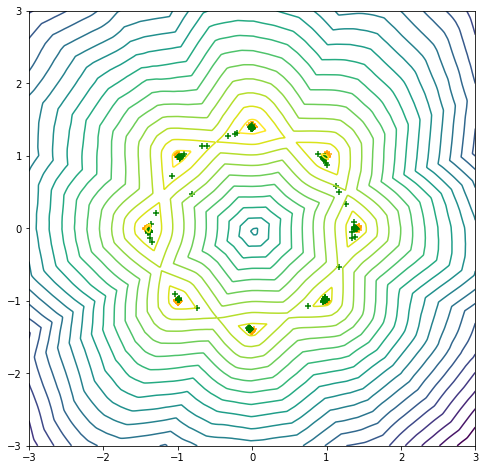

In [200]:
N_POINTS = 516
RANGE = 3
true_dist = next(dset)
points = np.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
points[:, :, 0] = np.linspace(-RANGE, RANGE, N_POINTS)[:, None]
points[:, :, 1] = np.linspace(-RANGE, RANGE, N_POINTS)[None, :]
points = points.reshape((-1, 2))

points_v = torch.from_numpy(points)
disc_map = netD(points_v).cpu().data.numpy()

noise = torch.randn(BATCH_SIZE, 2)

samples = netG(noise).cpu().data.numpy()

plt.clf()

x = y = np.linspace(-RANGE, RANGE, N_POINTS)
plt.figure(figsize=(8,8))
plt.contour(x, y, disc_map.reshape((len(x), len(y))).transpose(), 20)

plt.scatter(true_dist[:, 0], true_dist[:, 1], c='orange', marker='+')
plt.scatter(samples[:, 0], samples[:, 1], c='green', marker='+')

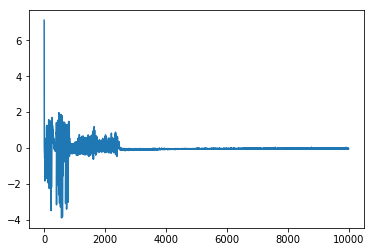

In [202]:
plt.plot(loss_dg_h[:,0])